# Full Method

Training and interpretation, with n_models simultaneously

#### import statements

In [1]:
import time
import datetime
import autoencodeSVJ.utils as utils
import autoencodeSVJ.evaluate as ev
import glob
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import glob
import os
import tensorflow as tf

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Using TensorFlow backend.


#### Function definitions

In [2]:
def get_signal_auc_df(aucs, n_avg=1, do_max=False):
    lp = None
    if do_max:
        lp = aucs.max(axis=1).to_frame().reset_index().rename(columns={0:'auc'})
    else:
        lp = aucs.iloc[
            :,np.argsort(aucs.mean()).values[::-1][:n_avg]
        ].mean(axis=1).to_frame().reset_index().rename(columns={0: 'auc'})

    lp['mass'] = lp.mass_nu_ratio.apply(lambda x: x[0])
    lp['nu'] = lp.mass_nu_ratio.apply(lambda x: x[1])
    
    lp = lp.drop('mass_nu_ratio', axis=1).pivot('mass','nu',  'auc')

    return lp
                                                
def plot_signal_aucs_from_lp(lp, n_avg=1, do_max=False, title=None, fac=1.5, barlabel=None, cmap='viridis'):

    plt.figure(figsize=(1.1*fac*6.9,1.1*fac*6))

    plt.imshow(lp, cmap=cmap)
    if barlabel == None:
        barlabel='AUC value'
    cb = plt.colorbar()
    cb.set_label(label=barlabel, fontsize=18*fac)

    plt.xticks(np.arange(0,5,1), map(lambda x: '{:.2f}'.format(x), np.unique(lp.columns)))
    plt.yticks(np.arange(0,6,1), np.unique(lp.index))
    
    if title is not None:
        plt.title(title, fontsize=fac*25)
    elif do_max:
        plt.title('Best AUCs (for any autoencoder)', fontsize=fac*25)
    elif n_avg < 2:
        plt.title('Signal AUCs (best autoencoder)', fontsize=fac*25)
    else:
        plt.title('Average Signal AUCs (best {} models)'.format(n_avg), fontsize=fac*25)
    plt.ylabel(r'$M_{Z^\prime}$ (GeV)', fontsize=fac*20)
    plt.xlabel(r'$r_{inv}$', fontsize=fac*20)
    plt.xticks(fontsize=18*fac)
    plt.yticks(fontsize=18*fac)

    for mi,(mass,row) in enumerate(lp.iterrows()):
        for ni,(nu,auc) in enumerate(row.iteritems()):
            plt.text(ni, mi, '{:.3f}'.format(auc), ha="center", va="center", color="w", fontsize=18*fac)

    return plt.gca()
                                                
def plot_signal_aucs(aucs, n_avg=1, do_max=False, title=None, fac=1.5, cmap='viridis'):
    lp = get_signal_auc_df(aucs, n_avg, do_max)
    return lp, plot_signal_aucs_from_lp(lp, n_avg, do_max, title, fac, cmap=cmap)                                    

#### do training, or load set of trainings we already did

trained 50 models on 10/3/2020

training 150 more starting 10/4/2020

200 total!

In [3]:
TRAIN = False

lr = .00051
lr_factor = 0.5
es_patience = 12
target_dim = 8
batch_size = 32
norm_percentile = 25
epochs = 100
n_models = 200                  # number of models to train
model_acceptance_fraction = 10 # take top N best performing models

start_stamp = time.time()
res = None
if TRAIN:
    for i in range(n_models):
        mse = ev.ae_train(
            signal_path='data/all_signals/2000GeV_0.15/base_3/*.h5',
            qcd_path='data/background/base_3/*.h5',
            target_dim=target_dim,
            verbose=False,
            batch_size=batch_size,
            learning_rate=lr,
            norm_percentile=norm_percentile,
            lr_factor=lr_factor,
            es_patience=es_patience,
            epochs=epochs
        )
        print('model {} finished (mse = {:.4f})'.format(i, mse))
        print
    
    res = utils.summary()
    res = res[pd.DatetimeIndex(res.start_time) > datetime.datetime.fromtimestamp(start_stamp)]

else:
    res = utils.summary()
    res = res.sort_values('start_time').tail(n_models)
    
# take lowest 10% losses of all trainings
n_best = int(0.01*model_acceptance_fraction*n_models)
best_ = res.sort_values('total_loss').head(n_best)
best_name = str(best_.filename.values[0])

# Results

## update & load AUC table

In [4]:
ev.update_all_signal_evals()

aucs = ev.load_auc_table()
bdts = pd.read_csv('autoencode/data/bdt_aucs.csv')
bdts = bdts[bdts.columns[1:]].set_index(bdts[bdts.columns[0]].rename('mass'))
bdts = bdts.T.set_index(bdts.T.index.rename('nu')).T
bdts.columns = map(float, bdts.columns)
bdts.index = map(float, bdts.index)

found 0 trainings total


## Plot AUCs and compare to specialized BDTs

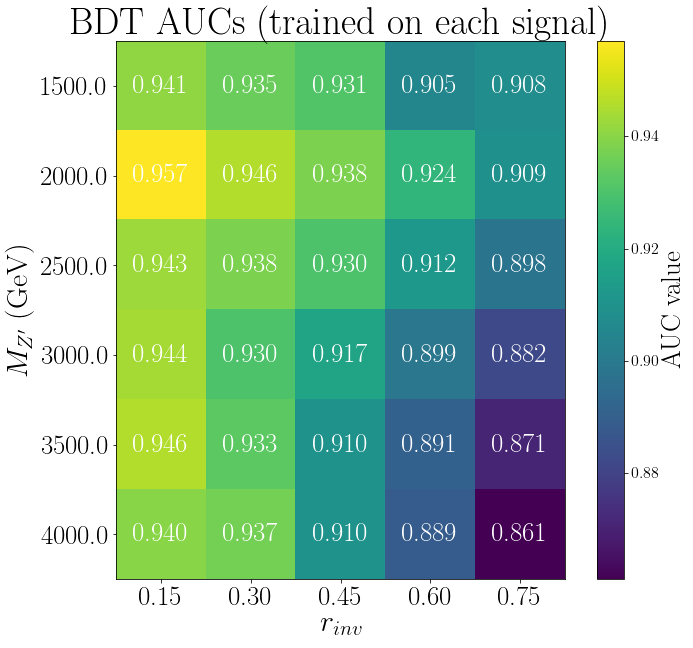

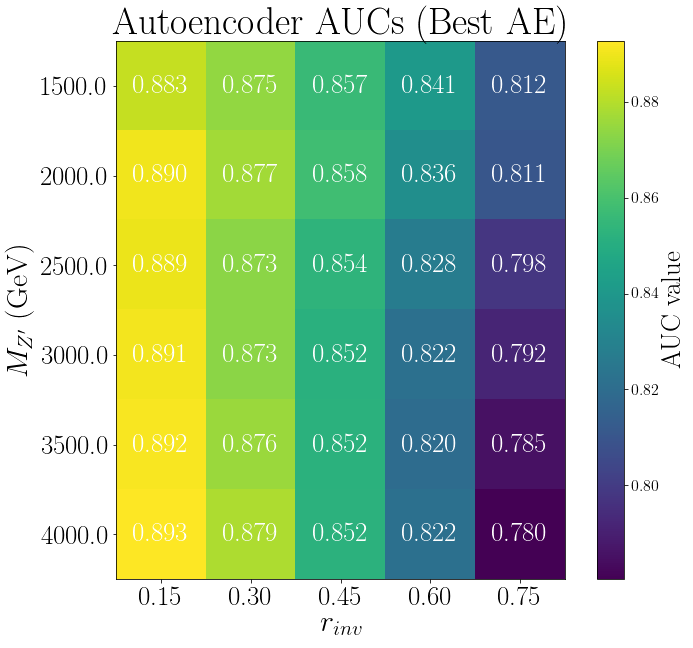

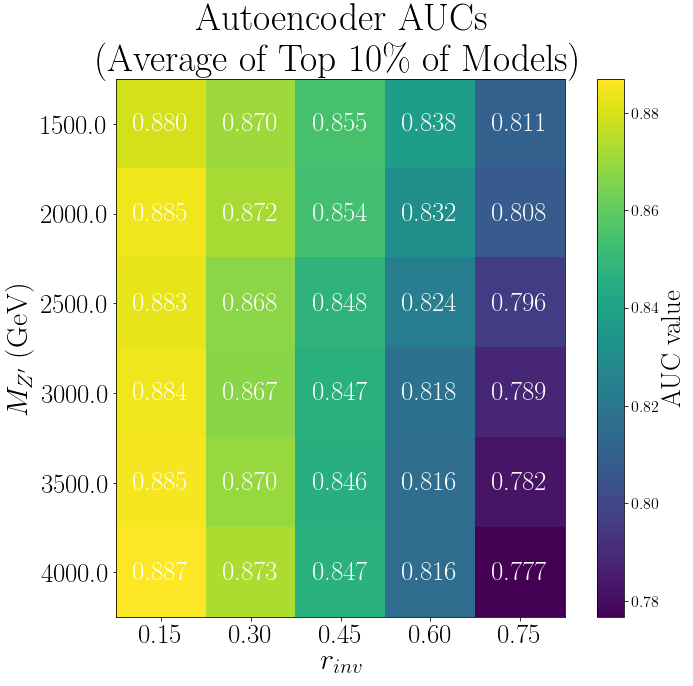

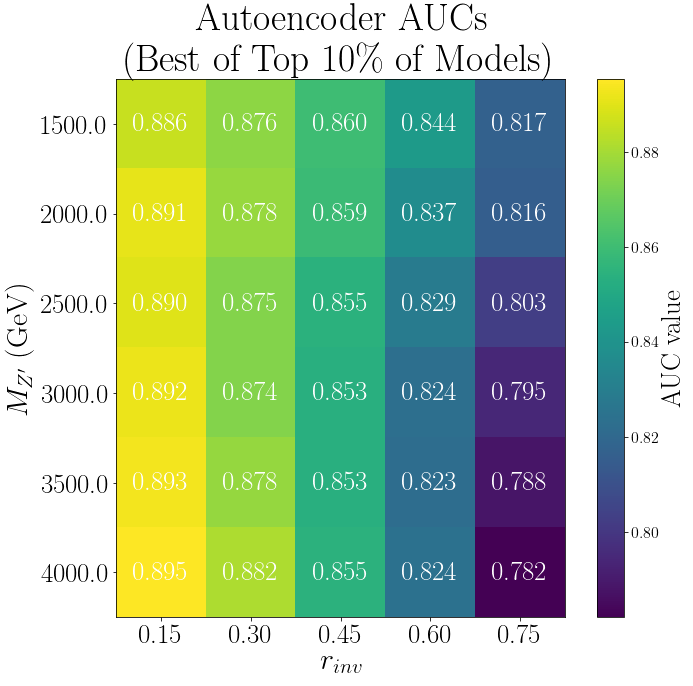

In [110]:
plot_signal_aucs_from_lp(bdts, title='BDT AUCs (trained on each signal)')
best,ax = plot_signal_aucs(aucs[best_name].to_frame(), title='Autoencoder AUCs (Best AE)')
best,ax = plot_signal_aucs(aucs[best_.filename], title='Autoencoder AUCs\n(Average of Top 10\% of Models)', n_avg=len(best_))
best,ax = plot_signal_aucs(aucs[best_.filename], do_max=1, title='Autoencoder AUCs\n(Best of Top 10\% of Models)', n_avg=len(best_))

## inputs and reconstructions

In [6]:
eflow_base = 3

dholder = ev.data_holder(
    qcd='data/background/base_3/*.h5',
    **{os.path.basename(p): '{}/base_{}/*.h5'.format(p, eflow_base) for p in glob.glob('data/all_signals/*')}
)

dholder.load()
dists = {v.name: v for v in dholder.get('data')}

signal = utils.data_table(pd.concat([v.df for v in dists.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')
qcd = dists['qcd']

found 31 datasets


In [73]:
# randomly choose one of the "best" models to view the behavior
to_evaluate = np.random.choice(best_.filename, 1)[0]

tf.reset_default_graph()
agetter = ev.auc_getter(to_evaluate, times=True)
agetter.update_event_range(dholder, percentile_n=1)
test = agetter.get_test_dataset(dholder)
norm, errors, recon = agetter.get_errs_recon(dholder, names=['mae', 'mse'], functions=['mae', 'mse'])
this_aucs = agetter.get_aucs(errors, metrics=['mae', 'mse'])
fmt = agetter.auc_metric(this_aucs)

found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow3_8_v321.summary'
:: TIME: init executed in 1.15 s
:: TIME: test dataset executed in 0.04 s
:: TIME: test dataset executed in 0.04 s
train_shell :: using saved model
:: TIME: recon gen executed in 16.74 s
:: TIME: auc grab executed in 1.20 s


In [74]:
dists_subset = [v for v in dists.values() if v.name.startswith('Zprime')]
size = min(map(len, dists_subset))
signal = utils.data_table(pd.concat([v.df.iloc[:size] for v in dists_subset]), name='Z^+ Dark (Average)')
signal_combined = pd.concat([pd.concat([v.df, pd.Series(np.repeat(k, len(v)), name='key')], axis=1) for k,v in dists.items() if k.startswith('Zprime')])
sc = signal_combined

sc['mass'] = sc.key.apply(lambda x: int(x.split('_')[1].rstrip('GeV')))
sc['nu'] = sc.key.apply(lambda x: float(x.split('_')[-1])/100.)
# sc.head()

signal_recon = utils.data_table(pd.concat([v.df.iloc[:size] for v in recon.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average) pred')
signal_norm = utils.data_table(pd.concat([v.df.iloc[:size] for v in norm.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')
signal_err = utils.data_table(pd.concat([v.df.iloc[:size] for v in errors.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')

In [532]:
styles = {
    'Z': {
        'facecolor': 'm',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'SVJ',
        'alpha': 0.4,
#         'hatch': '/'
    },
    'qcd': {
        'facecolor': 'y',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'QCD',
        'alpha': 0.4

    },
    'ttbar': {
        'facecolor': 'C0',
        'label': r'$t\bar{t}$',
        'edgecolor': 'w',
        'hatch': '//',
        'fill': True,
        'histtype': 'step',
        'alpha': 0.4

    }
}

order = [
    'ttbar',
    'Z',
    'qcd'
]


var_styles = {
    'ChargedFraction': {
        'xlabel': r'Charged Fraction',
        'fontsize': 20,
    },
    'Pt': {
        'xlabel': r'$\displaystyle p_{T}$',
        'fontsize': 20,
        'range': (0., 2000.),
        'ylog': True
    },
    'Eta': {
        'xlabel': r'$\displaystyle \eta$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'Phi': {
        'xlabel': r'$\displaystyle \phi$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'M': {
        'xlabel': 'Mass',
        'fontsize': 20,
        'range': (0., 750.),
        'ylog': True,
    },
    'mae': {
        'xlabel': 'Reconstruction Error (MAE)',
        'fontsize': 30,
    },
    'mse': {
        'xlabel': 'Reconstruction Error (MSE)',
        'fontsize': 30,
    },
    'mae_minus_etaphi': {
        'xlabel': 'Reconstruction Error (MAE - eta/phi)',
        'fontsize': 30,
    },
    'PTD': {
        'xlabel': 'PTD',
        'fontsize': 20,
    },
    'Axis2': {
        'xlabel': 'Axis_2',
        'fontsize': 20,
        'range': (0, 0.2)
    }
}

# more than needed
for i in range(100):
    var_styles['eflow {}'.format(i)] = {}
    var_styles['eflow {}'.format(i)]['xlabel'] = "Variable {}".format(i)
    var_styles['eflow {}'.format(i)]['fontsize'] = 20
    var_styles['eflow {}'.format(i)]['ylog'] = True
#     var_styles['eflow {}'.format(i)]['range'] = (0,1)
    
# eflow_ranges = {
#     1: (0,0.75),
#     2: (0,0.5),
#     3: (0,0.4),
#     4: (0,0.4),
#     5: (0,0.25),
#     6: (0,0.15),
#     7: (0,0.2),
#     8: (0,0.15),
#     9: (0,0.3),
#     10: (0,0.2),
#     11: (0,0.15),
#     12: (0,0.15)
# }

# for num,rng in eflow_ranges.items():
#     var_styles['eflow {}'.format(num)]['range'] = rng
    
from collections import OrderedDict

def converter(toplot): 
    colsets = [tuple(x.columns) for x in toplot.values()]
    assert(len(set(colsets)) == 1)
    var = colsets[0]

    names = sorted(toplot.keys())

    out = OrderedDict()
    for name in names:
        for v in var:
            if v not in out:
                out[v] = OrderedDict()
            out[v][name] = toplot[name][v]

    return out

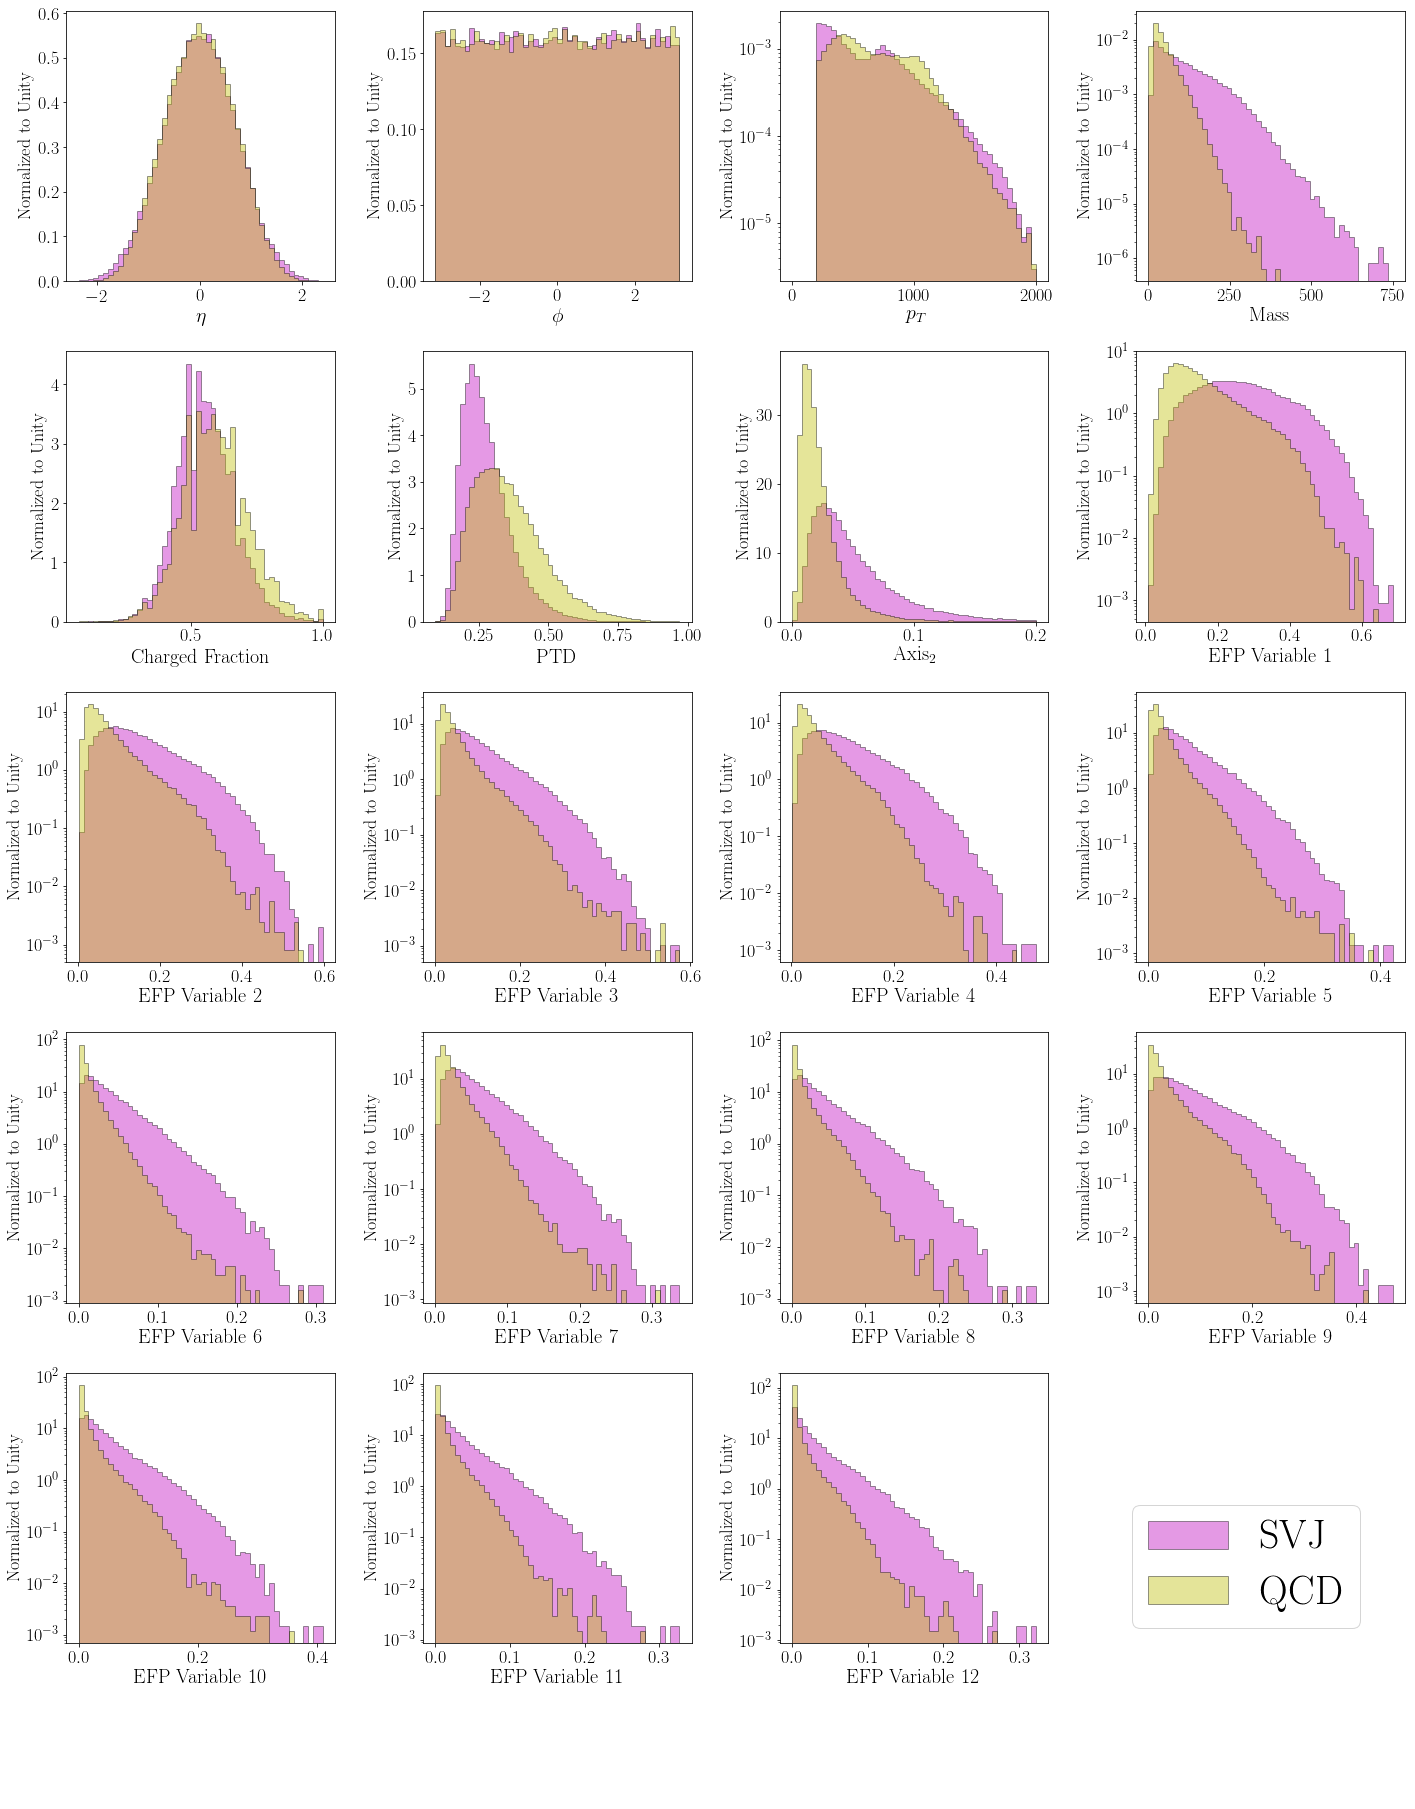

In [536]:
data = converter({'Z': signal, 'qcd': qcd})

bins=50
names="*"
ylabel='Normalized to Unity'
normed=1
xlog=False
ylog=False
pileup=False
m1 = 20./4.
m2 = 14./3.


fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins
i = 0
for d,v in data.items():
    var_style = var_styles[d].copy()

    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')
    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])

    ylog_ = ylog
    if 'ylog' in var_style:
        ylog_ = var_style.pop('ylog')
        
    ax = axs[i]

    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[k].copy()

#             style['alpha'] = 0.3
        ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)


        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')

        if xlog:
            ax.set_xscale('log')
        if ylog_:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(0.8, 0.1), fontsize=40)
for x in axs[i:]:
    f.delaxes(x)
    
plt.savefig('plot/variable_plot.pdf', pdf=1, bbox_inches='tight')

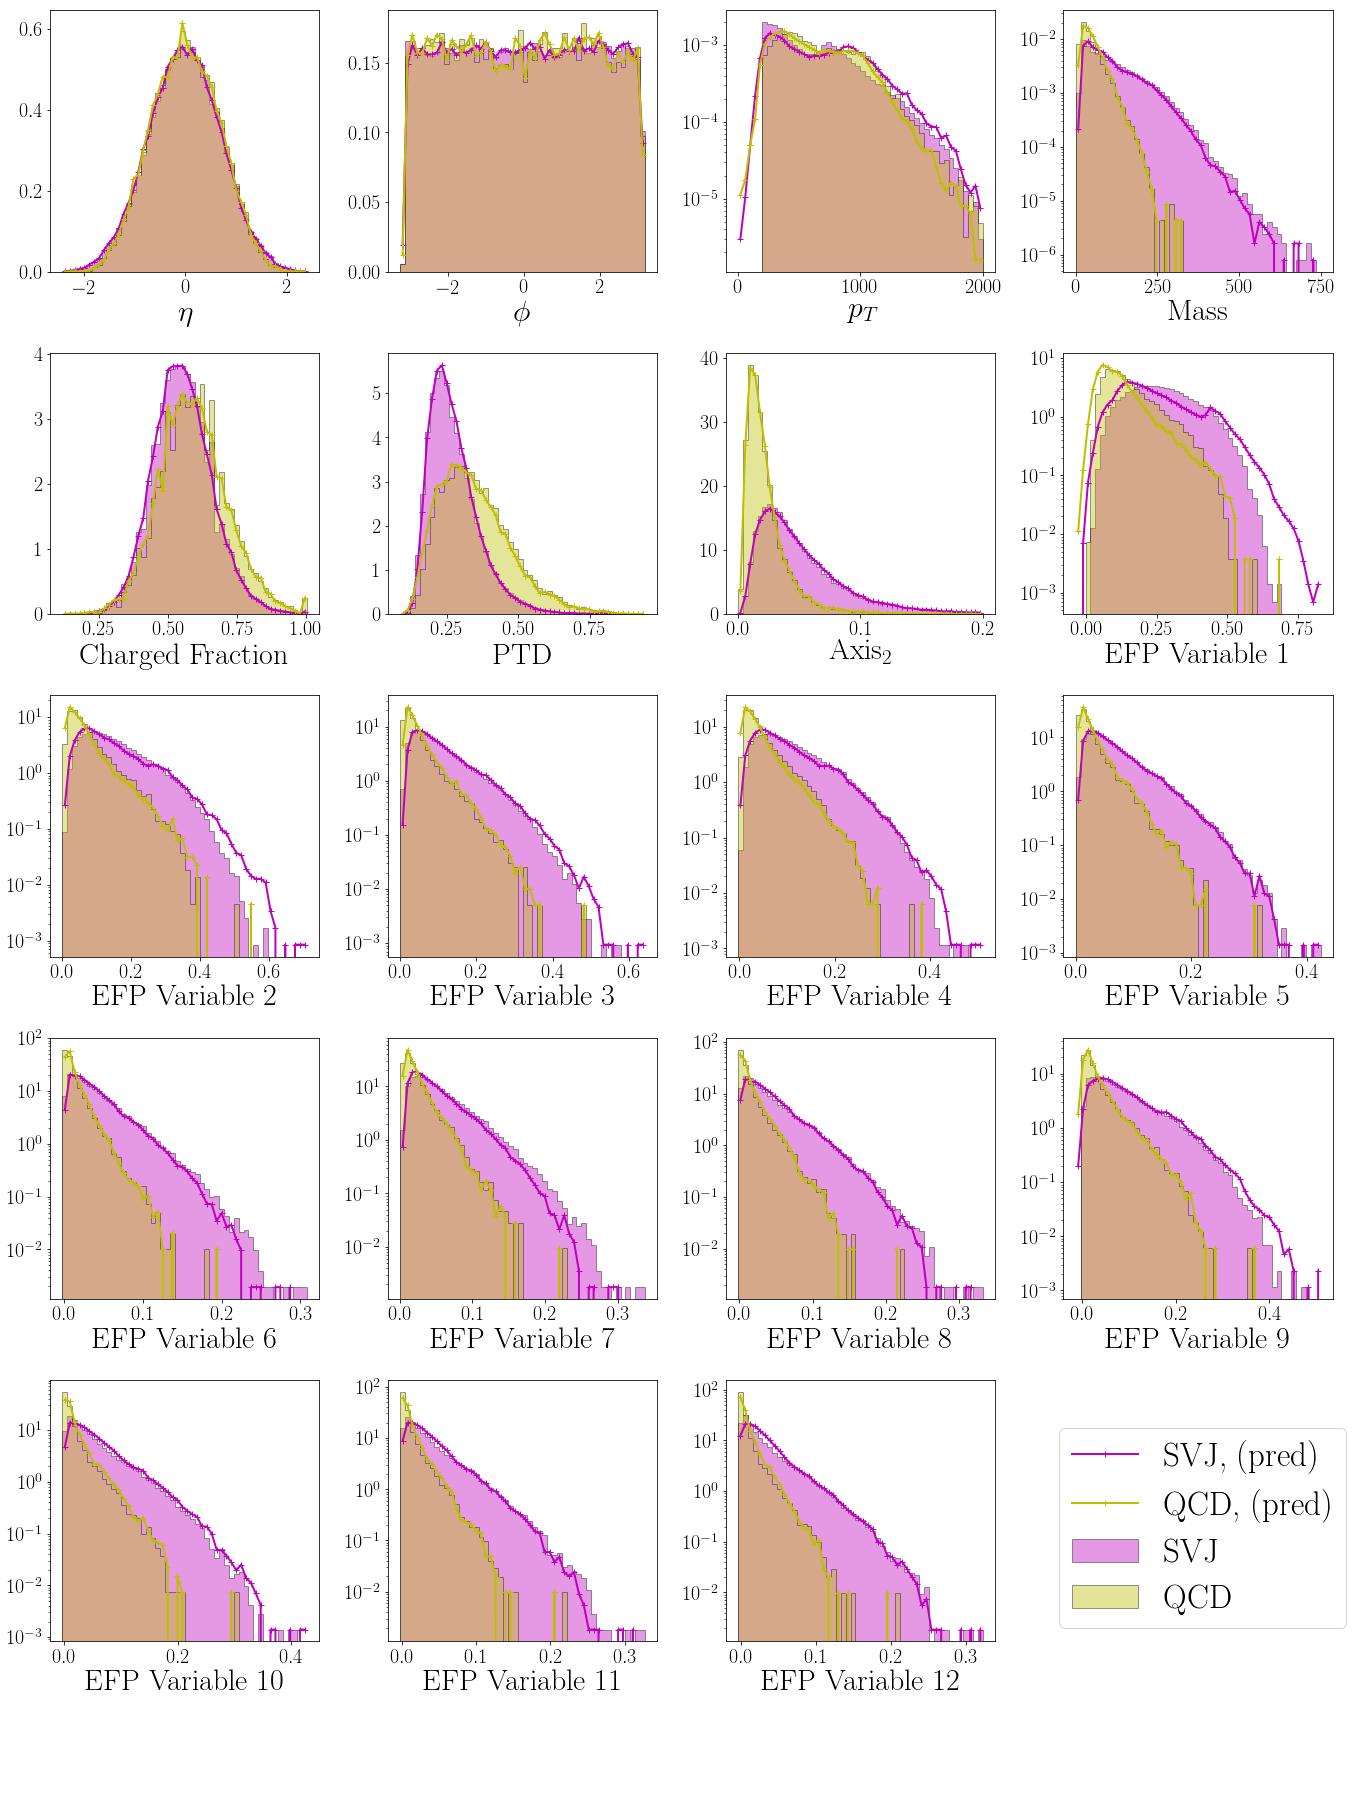

In [535]:
data = converter({
    'Z pred': signal_recon,
    'qcd pred': recon['qcd pred'],
    'Z': signal, 
    'qcd': test
})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 19./4.
m2 = 14./3.

recon_kwd = 'pred'
# dists = e.dists_dict.copy()
# dists['qcd'] = e.test
# data = plotdata({recon_kwd : e.recons_dict, 'NONE': dists}, names=names)

fs = 20
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
# f.suptitle("Feature Reconstructions", y=1.02, fontsize=30)
ogbins = bins
i = 0

for da,v in data.items():
    
    var_style = var_styles[da].copy()
    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
    
    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins
    ylog_ = ylog
    if 'ylog' in var_style:
        ylog_ = var_style.pop('ylog')
    
    if 'range' in var_style:
        rng = var_style.pop('range')
    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]
        reconstructed = False
        kp = k 
        if recon_kwd in k:
            reconstructed = True 

            kp = k.replace(recon_kwd, '').strip()

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[kp].copy()

#             style['alpha'] = 0.3
        if reconstructed:
            hist,bins = np.histogram(datum, range=rng, bins=nbins, normed=normed)

            style['color'] = style['facecolor']
            style['linewidth'] = 2
            style['label'] = style['label'] + ', (pred)'
            for var in ['histtype', 'fill', 'facecolor', 'edgecolor', 'hatch', 'alpha']:
                if var in style:
                    style.pop(var)

            ax.plot(bins[:-1] + np.diff(bins)/2., hist, marker='+', alpha=1, **style)
#                 ax.scatter(bins[:-1] + np.diff(bins)/2., hist, marker='+', edgecolor='k', **style)
        else:
            ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)

        var_style['fontsize'] = 30
        ax.set_xlabel(**(var_style))
        
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog_:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)
#         ax.set_yticklabels([])

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7825,.1), fontsize=33)
for x in axs[i:]:
    f.delaxes(x)
    
plt.savefig('plot/reconstruction_plot.pdf', pdf=1, bbox_inches='tight')

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in divide
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in divide
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in multiply
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in divide


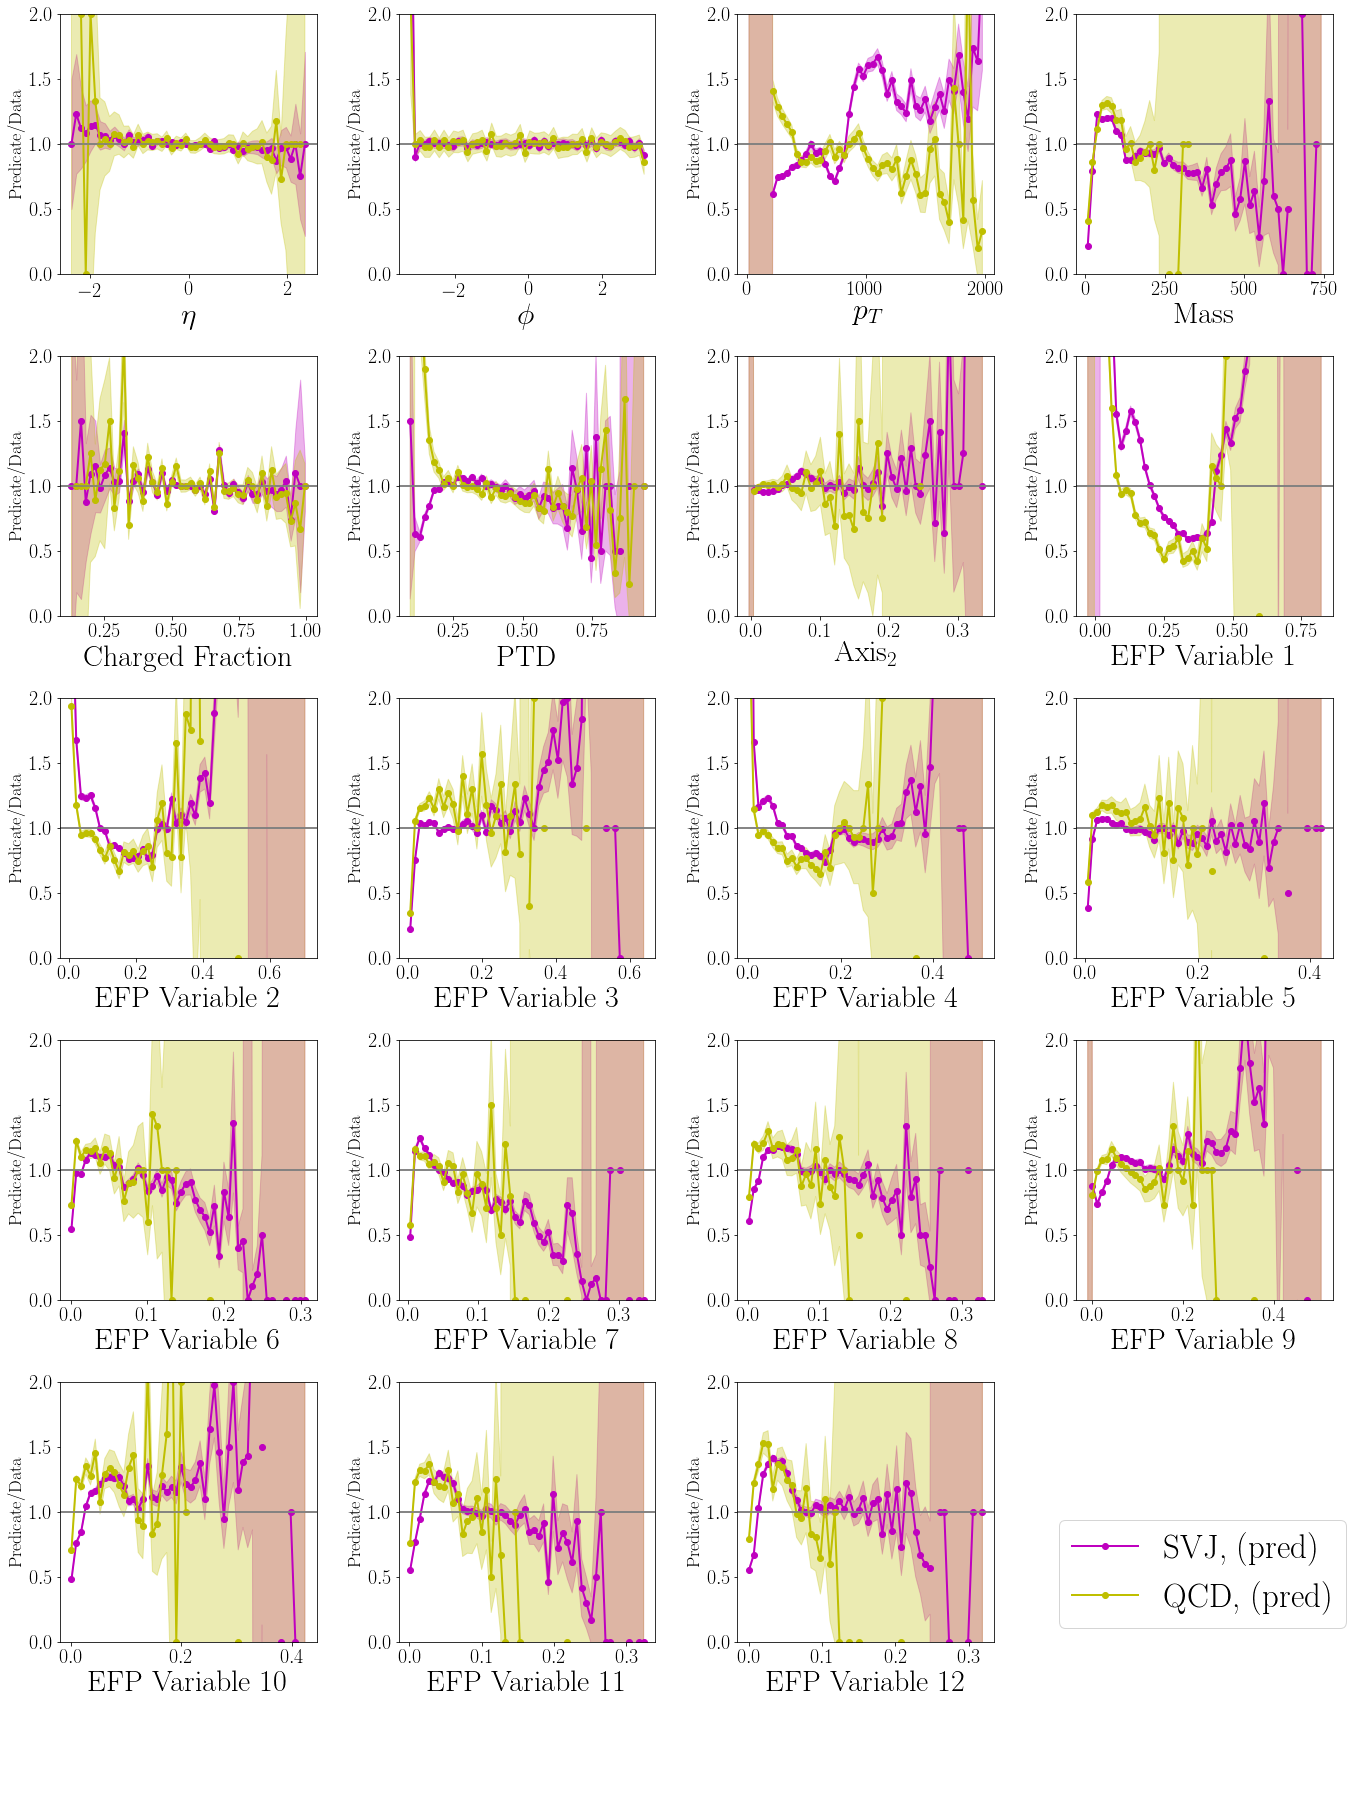

In [84]:
pred_names = ['Z', 'qcd']
data = converter({
    'Z pred': signal_recon,
    'qcd pred': recon['qcd pred'],
    'Z': signal, 
    'qcd': test
})

bins=50
names="*"
ylabel='Predicate/Data'
normed=1
xlog=False
ylog=False
pileup=False
m1 = 19./4.
m2 = 14./3.

recon_kwd = 'pred'
# dists = e.dists_dict.copy()
# dists['qcd'] = e.test
# data = plotdata({recon_kwd : e.recons_dict, 'NONE': dists}, names=names)

fs = 20
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
# f.suptitle("Feature Reconstructions", y=1.02, fontsize=30)
ogbins = bins
i = 0

for da,v in data.items():
    
    var_style = var_styles[da].copy()
    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
    
    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')

    ylog_ = ylog
    if 'ylog' in var_style:
        ylog_ = var_style.pop('ylog')
        
    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    ksets = [sorted(filter(lambda x: x.startswith(nme), v.keys())) for nme in pred_names]
    for kset in ksets:

        for k in kset:
            datum = v[k]
            reconstructed = False
            kp = k 
            if recon_kwd in k:
                reconstructed = True 

                kp = k.replace(recon_kwd, '').strip()

            if pileup:
                datum[datum < rng[0]] = rng[0]
                datum[datum > rng[1]] = rng[1]
            nbins = bins
            if xlog:
                nbins = np.geomspace(rng[0], rng[1], bins)

            style = styles[kp].copy()

    #             style['alpha'] = 0.3
            if reconstructed:
                recon_hist,recon_bins = np.histogram(datum, range=rng, bins=nbins, normed=0)
            else:
                hist, bins = np.histogram(datum, range=rng, bins=nbins, normed=0)

        style['color'] = style['facecolor']
        style['linewidth'] = 2
        style['label'] = style['label'] + ', (pred)'
        for var in ['histtype', 'fill', 'facecolor', 'edgecolor', 'hatch', 'alpha']:
            if var in style:
                style.pop(var)
                
        recon_hist,hist = recon_hist.astype(float), hist.astype(float)
        xpt = bins[:-1] + np.diff(bins)*.5
        
        Ratio = recon_hist/hist
        
        ax.plot(xpt, Ratio, marker='o', alpha=1, **style)
        error_ = (Ratio)*np.sqrt(1./recon_hist + 1./hist)
        error_[~np.isfinite(error_)] = 20
        
        Ratio[~np.isfinite(Ratio)] = 1
        ax.fill_between(xpt, Ratio -error_, Ratio + error_, color=style['color'], alpha=.3)
        
#             style['color'] = style['facecolor']
#             style['linewidth'] = 2
#             style['label'] = style['label'] + ', (pred)'
#             for var in ['histtype', 'fill', 'facecolor', 'edgecolor', 'hatch', 'alpha']:
#                 if var in style:
#                     style.pop(var)

#             ax.plot(bins[:-1] + np.diff(bins)/2., hist, marker='+', alpha=1, **style)
# #                 ax.scatter(bins[:-1] + np.diff(bins)/2., hist, marker='+', edgecolor='k', **style)
#         else:
#             ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)

        ax.axhline(1, color='tab:grey')
        ax.set_ylim(0, 2)
        var_style['fontsize'] = 30
        ax.set_xlabel(**(var_style))
        
#             ax.set_yscale('log')
#         if xlog:
#             ax.set_xscale('log')
#         if ylog_:
#             ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)
#         ax.set_yticklabels([])

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7825,.1), fontsize=33)
for x in axs[i:]:
    f.delaxes(x)

In [ ]:
loss_to_use = 'mse'
loss_range = (0, 0.025)

import random

N0 = 12000

# N = 6*N0/5


keys = errors.keys()
keys.remove('qcd')
keys = pd.DataFrame(keys, columns=['key'])
keys['nu'] = keys.key.apply(lambda x: x.split('_')[-1]).astype(float)/100.
keys['mass'] = keys.key.apply(lambda x: x.split('_')[-2].replace('GeV', '')).astype(int)
se_idx = random.sample(list(set(signal_err.index)), N0/6)

newdata = {}
for nu, gp in keys.groupby('nu').key:
     newdata[nu] = pd.concat([errors[k].df.loc[se_idx] for k in gp])
    

# se_idx = random.sample(list(set(signal_err.index)), N//30)
qe_idx = random.sample(range(len(errors['qcd'])), N0)

inp = {'qcd': errors['qcd'].iloc[qe_idx]}
inp.update(newdata)
data = converter(inp)
for k in data.keys():
    if k != loss_to_use:
        data.pop(k)

bins=40
ylabel=None
normed=0
xlog=False
ylog=True
pileup=False
rng=loss_range

#     recon_kwd = '(Reconstructed)'
#     data = plotdata(e.errs_dict, names=names, drop=drop)

fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 30})

#     rows, cols = (1,1)
f, ax = plt.subplots(1, 1, figsize=(2*m1, 2*m2))

#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins

stack = []
for d,v in data.items():
    if 'bins' in var_styles[d]:
        bins = var_styles[d].pop('bins')
    else:
        bins = ogbins

    if 'range' in var_styles[d]:
        rng = var_styles[d].pop('range')
    else:
        rng = None
    rng = (0, 0.025)
    if rng is None:
        rng = map(lambda f: f(map(f, v.values())), [min, max])


#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
       
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        if k in styles:
            style = styles[k].copy()
            ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)
        else:
            stack_elt = np.histogram(datum, range=rng, bins=nbins, normed=normed)
            cnts,bns = stack_elt
            plt.plot(bns[:-1] + .5*np.diff(bns), cnts, label=r'SVJ, $r_{inv} = ' + '{}$'.format(str(k)))
            stack.append(stack_elt)
            
        var_style = var_styles[d].copy()
        if 'Variable' in var_style['xlabel']:
            var_style['xlabel'] = "EFP " + var_style['xlabel'] 

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        
        if xlog:
            ax.set_xscale('log')
        if ylog:
            plt.ylim(.8*1e0,1e4)

            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

# ax.set_ylabel('Arbitrary Units')
# ax.set_yticklabels([])
# plt.yscale('log')
handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.62,.56), fontsize=22)
plt.title('Reconstruction Error\n($N$ = {} Events/Class)'.format(N0))
plt.ylabel('Count')
plt.savefig('plot/reconstruction_err.pdf', pdf=1, bbox_inches='tight')

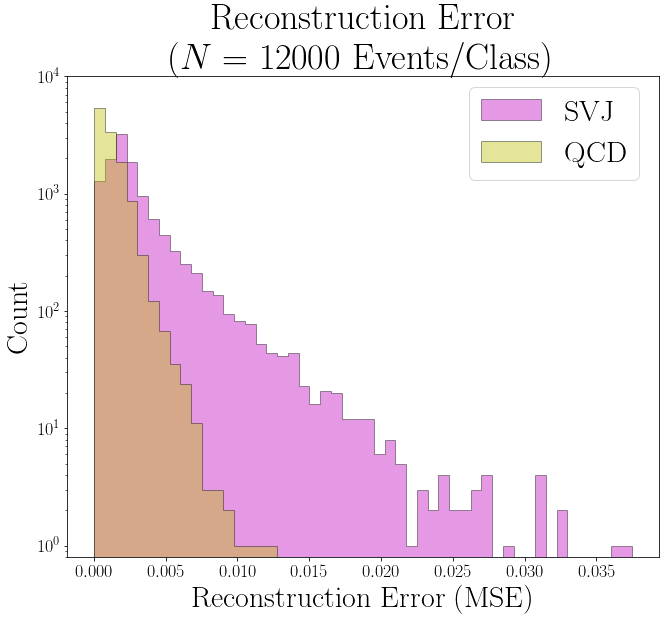

In [607]:
N = 12000

se_idx = random.sample(range(len(signal_err.index)), N)
qe_idx = random.sample(range(len(errors['qcd'])), N)
data = converter({'Z': signal_err.iloc[se_idx], 'qcd': errors['qcd'].iloc[qe_idx]})
for k in data.keys():
    if k != loss_to_use:
        data.pop(k)
# print(data['mae']['Z'].max())
bins=50
ylabel=None
normed=0
xlog=False
ylog=True
pileup=False
rng=loss_range
split=True

#     recon_kwd = '(Reconstructed)'
#     data = plotdata(e.errs_dict, names=names, drop=drop)

fs = 18
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['figure.autolayout'] = True
# plt.rcParams['xtick.labelsize']=fs
# plt.rcParams['ytick.labelsize']=fs
# matplotlib.rcParams.update({'font.size': 30})

#     rows, cols = (1,1)
f, ax = plt.subplots(1, 1, figsize=(2*m1, 2*m2))

#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins

for d,v in data.items():
    if 'bins' in var_styles[d]:
        bins = var_styles[d].pop('bins')
    else:
        bins = ogbins

    if 'range' in var_styles[d]:
        rng = var_styles[d].pop('range')
    else:
        rng=None
    rng=None
    if rng is None:
        rng = map(lambda f: f(map(f, v.values())), [min, max])


#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
       
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[k].copy()

#             style['alpha'] = 0.3
        ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)

        var_style = var_styles[d].copy()
        if 'Variable' in var_style['xlabel']:
            var_style['xlabel'] = "EFP " + var_style['xlabel'] 

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            plt.ylim(.8*1e0,1e4)

            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

# ax.set_ylabel('Arbitrary Units')
# ax.set_yticklabels([])
# plt.yscale('log')
handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7,.71), fontsize=30)
plt.title('Reconstruction Error\n($N$ = {} Events/Class)'.format(N))
plt.ylabel('Count')
plt.savefig('reconstruction_plot_combined.pdf', pdf=1, bbox_inches='tight')

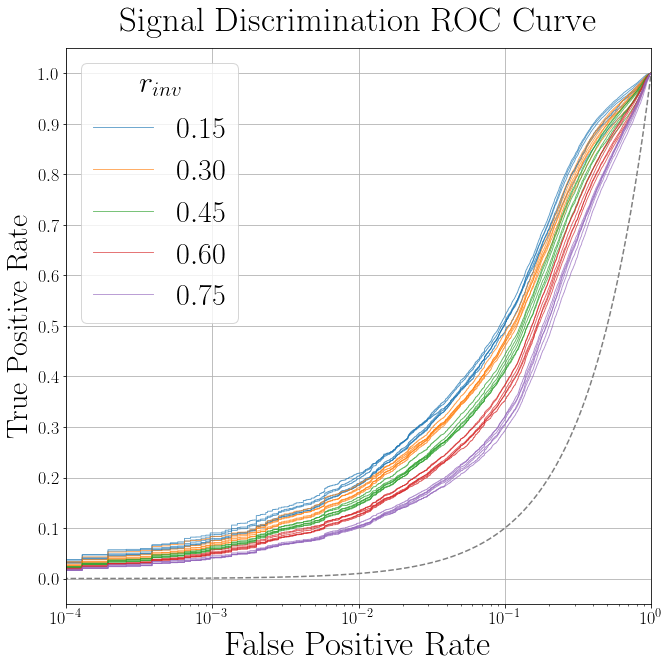

In [630]:

from matplotlib import lines as mplines
# errs = e.roc(figsize=10, yscale='log', xscale='log', figname='SVJ vs. QCD error', fontsize=20, show_plot=0)

plt.figure(figsize=(10,10))
aucplot = this_aucs.copy()

keys = aucplot.keys()
# keys.remove('qcd')
keys = pd.DataFrame(keys, columns=['key'])
keys['nu'] = keys.key.apply(lambda x: x.split('_')[-1]).astype(float)/100.
keys['mass'] = keys.key.apply(lambda x: x.split('_')[-2].replace('GeV', '')).astype(int)
se_idx = random.sample(list(set(signal_err.index)), N0/6)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# all_colors = prop_cycle.by_key()['color']
all_lines = ['-', '--', '-.', ':', '-']
all_markers = ['x', 'o', 'v', 'D', 's', 'P']
# all_lines = ["s", "o", "d", "x", "1"]

masses, nus = map(set, np.asarray([[err.split('_')[1], '{:.2f}'.format(int(err.split('_')[2])/100.)] for err in errors.keys() if len(err.split('_')) >= 3]).T)
# colors = OrderedDict([(nu, all_colors[i]) for i,nu in enumerate(nus)])
lines = {nu: '-' for i,nu in enumerate(nus)}
markers = {mass: all_markers[i] for i,mass in enumerate(masses)}


dots = np.logspace(-3, -2, len(aucplot))
# index = np.argsort([(k, v['mae']['auc']) for k,v in aucplot.items()],axis=0)[:,1]
index = np.argsort([(k, v['mse']['roc'][1][np.argmin(abs(v['mse']['roc'][0] - 2*1e-3))]) for k,v in aucplot.items()], axis=0)[:,1]

used_labels = set()
used_styles = OrderedDict()

for i,(nu, gp) in enumerate(keys.groupby('nu').key):
    for a in gp:
        for typ in aucplot[a]:
            if typ != 'mse':
                continue
            mass,nu = a.split('_')[1:]
            nu = '{:.2f}'.format(int(nu)/100.)
            roc = aucplot[a][typ]['roc']
            auc = aucplot[a][typ]['auc']

            lab = r'${}$'.format(nu)
            if lab in used_labels:
                lab = None
            used_labels.add(lab)


    #         nex = dots[index[i]]
            idxs = [np.argmin(abs(roc[0] - x)) for x in np.logspace(-3, 0, 10)]
            nex = 2e-3
    #         xplt = np.argmin(abs(roc[0] - nex))

            
            plt.plot(roc[0], roc[1], linestyle=lines[nu], c=colors[i], label=lab, linewidth=0.9, alpha=.7) 
            used_styles[(nu, mass)] = plt.plot(
                roc[0][idxs], roc[1][idxs], marker=None,#markers[mass],
                markeredgecolor=colors[i], markerfacecolor='None',
                markersize=6, linestyle='None'
            )
            
        
    #, label=r'${}$, Nu={}'.format(mass, nu))
    
xpar = np.logspace(-7, 0, 500)
plt.plot(xpar, xpar, linestyle='--', c='grey')
plt.xlabel('False Positive Rate', fontsize=35)
plt.ylabel('True Positive Rate', fontsize=30)
plt.title('Signal Discrimination ROC Curve', fontsize=35, y=1.02)
plt.xscale('log')
plt.legend(title=r'$r_{inv}$', fontsize=30)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().grid()
plt.ylim(-.05, 1.05)
plt.xlim(1e-4, 1)
# plt.
plt.savefig('plot/roc_curve.pdf', pdf=1, bbox_inches='tight')
plt.show()

### Plot S/B and S/sqrt(B)

$\sigma = \frac{S}{\sqrt{B}}$ as a function of the cut on the metric output (MSE or MAE) yields the relative increase in signal significance. 

Please ask me (luclepot@umich.edu) about this quantity if it is unknown

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in divide
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide


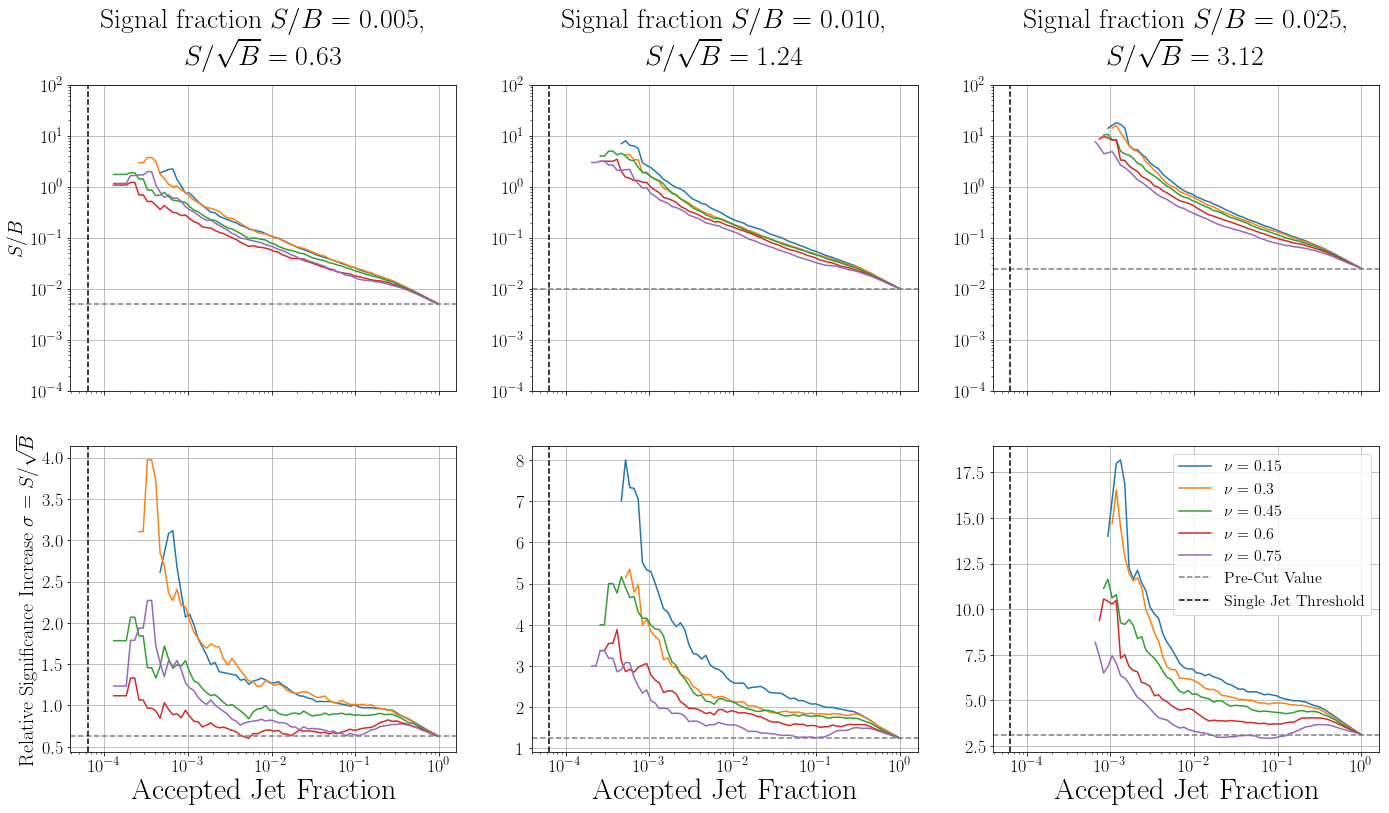

In [624]:
signal_fracs = [0.005, 0.01, 0.025]
cut_rates = 100*(1 - np.logspace(-5, 0, 100))

qcd_error = errors['qcd'].df

cnts_by_thresh = {}

for signal_name in errors:
    sig_error = errors[signal_name].df
    cnts_by_thresh[signal_name] = {}
    for r in signal_fracs:

        N_sig = int(np.round(len(qcd_error)*r,0))
        tsig_err = sig_error.sample(N_sig, replace=False)
        comb = pd.concat([qcd_error, tsig_err], axis=0)
        ycomb = np.concatenate([np.zeros(len(qcd_error)), np.ones(len(tsig_err))]).astype(bool)

        thresh = np.percentile(comb.T, cut_rates, axis=1)
        pass_thresh = (comb.values[:,None] > thresh[None,:])

        Nsig = (ycomb[:,None,None] & pass_thresh).sum(axis=0)
        Nqcd = ((~ycomb[:,None,None]) & pass_thresh).sum(axis=0)
        cnts_by_thresh[signal_name][r] = (Nsig, Nqcd)

fig, axes = plt.subplots(2, 3, figsize=(20,12), sharex=True)

# axs = axes[0,:]
for i,r in enumerate(signal_fracs):
    for nu, grp in keys.groupby('nu').key:
        cnts = np.asarray([cnts_by_thresh[s][r] for s in grp.values])
        Nsigt,Nqcdt = cnts[:,0,:,0].astype(float), cnts[:,1,:,0].astype(float)
        axes[0,i].plot(1 - 0.01*cut_rates, np.nanmean(Nsigt/Nqcdt, axis=0))
        axes[1,i].plot(1 - 0.01*cut_rates, np.nanmean(Nsigt/np.sqrt(Nqcdt), axis=0), label=r'$\nu = {}$'.format(nu))
    
    for axs in axes:
        axs[i].set_xscale('log')
#         axs[i].set_xlim(.8*, 1.2*1e0)
        axs[i].grid()
        
    axes[0,i].set_yscale('log')
    axes[0,i].set_ylim(1e-4, 1e2)
    
    axes[1,i].set_xlabel('Accepted Jet Fraction')
    axes[1,i].axhline(Nsigt[0,-1]/np.sqrt(Nqcdt[0,-1]), ls='--', color='tab:grey', label='Pre-Cut Value')
    axes[0,i].axhline(Nsigt[0,-1]/Nqcdt[0,-1], ls='--', color='tab:grey', )
    axes[0,i].set_title(
        'Signal fraction $S/B = {:.3f}$,\n$S/\sqrt{{B}} = {:.2f}$'.format(Nsigt[0,-1]/Nqcdt[0,-1], Nsigt[0,-1]/np.sqrt(Nqcdt[0,-1])),
        y=1.05, fontsize=28
    )
    zero_event_thresh = 1/(Nsigt[0,-1] + Nqcdt[0,-1])
    axes[0,i].axvline(zero_event_thresh, color='black', ls='--')
    axes[1,i].axvline(zero_event_thresh, color='black', ls='--', label='Single Jet Threshold')
    
axes[-1,-1].legend(fontsize=16)
axes[0,0].set_ylabel('$S/B$', fontsize=20)
axes[1,0].set_ylabel('Relative Significance Increase $\sigma = S/\sqrt{B}$', fontsize=20)
# axs = axes[1,:]
# for i,r in enumerate(signal_fracs):
#     for nu, grp in keys.groupby('nu').key:
#         cnts = np.asarray([cnts_by_thresh[s][r] for s in grp.values])
#         Nsigt,Nqcdt = cnts[:,0,:,0].astype(float), cnts[:,1,:,0].astype(float)
#         axs[i].plot(1 - 0.01*cut_rates, np.nanmean(Nsigt/Nqcdt, axis=0))
#     axs[i].set_xscale('log')
#     axs[i].set_xlim(.8*1e-3, 1.2*1e0)
#     axs[i].set_yscale('log')
#     axs[i].set_ylim(1e-4, 1e2)
#     axs[i].set_ylabel('S/B')
#     axs[i].grid()
#         axs[i].set_xlabel('Fraction of Events Remaining')
plt.tight_layout()
plt.savefig('plot/sb_ratios_relsigs.pdf', bbox_inches='tight', pdf=True)

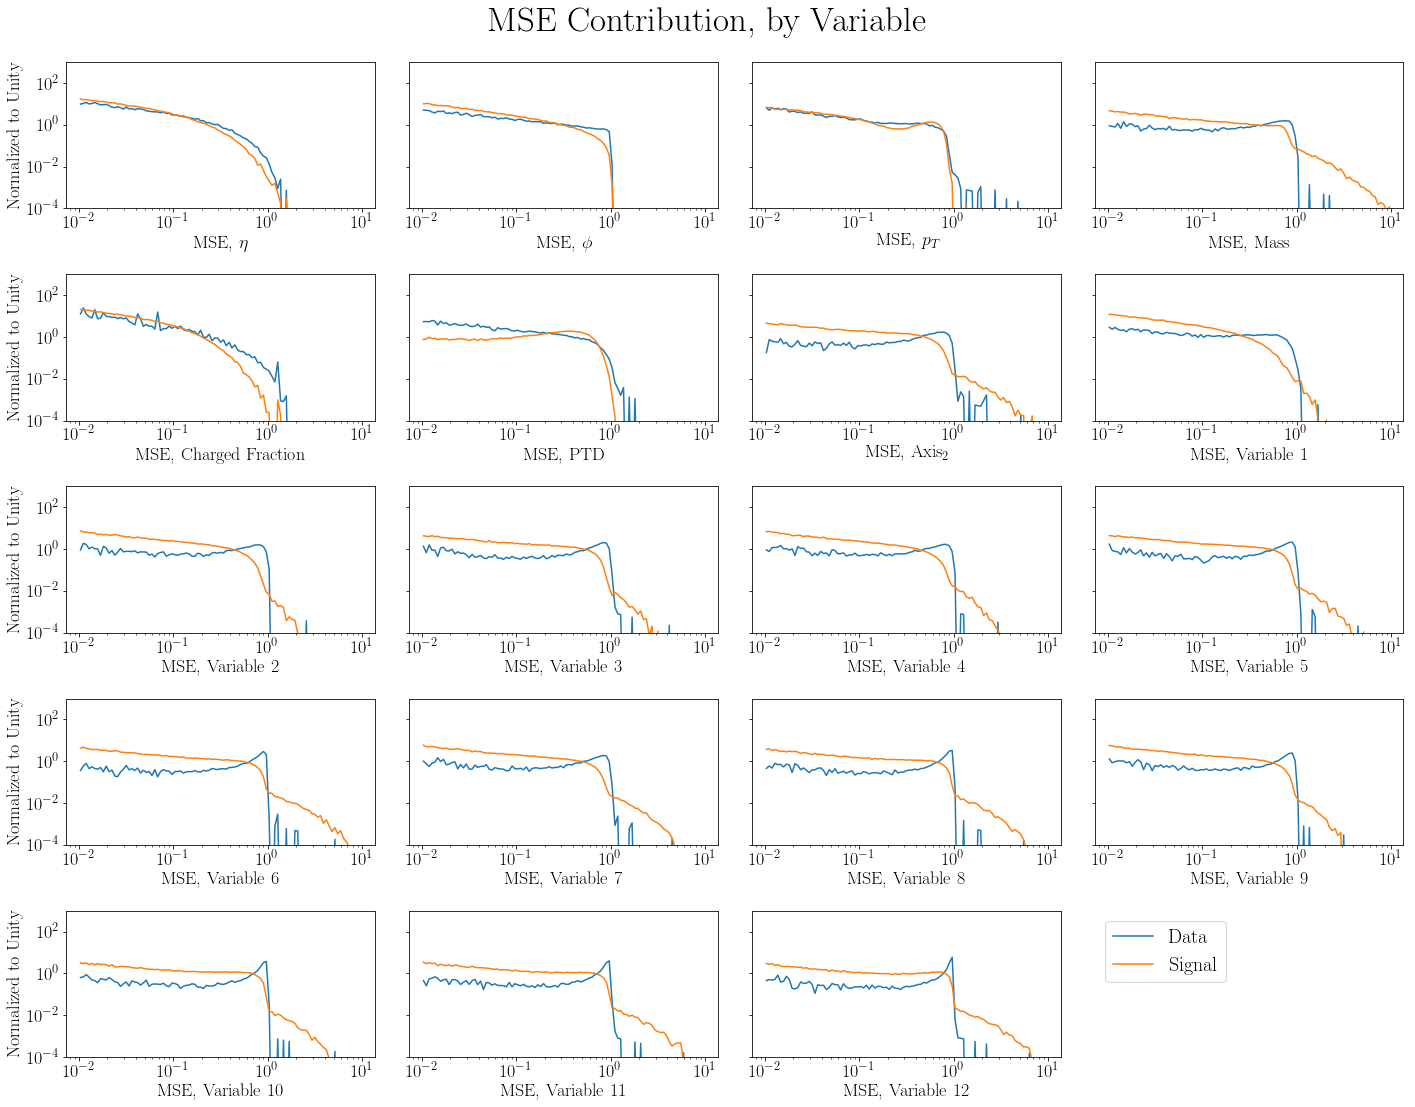

In [565]:
snmin, snmax = np.asarray(agetter.d['range']).T
signal_recon_norm = (signal_recon - smin) / (smax - smin)
qcd_recon_norm = (recon['qcd pred'] - smin)/(smax - smin)
qcd_norm = norm['qcd']

signal_err_each = (signal_recon_norm - signal_norm.df)**2.
qcd_err_each = (qcd_recon_norm - qcd_norm.df)**2.

e_percentile = np.percentile(pd.concat([df_combine.mean(axis=1), df_combine_qcd.mean(axis=1)]), 95)

df_combine_sub = df_combine[df_combine.mean(axis=1)>e_percentile]
df_combine_sub_qcd = df_combine_qcd[df_combine_qcd.mean(axis=1)>e_percentile]

df_combine = signal_err_each
df_combine_qcd = qcd_err_each

cols_to_use = df_combine.mean().sort_values().tail(5).index
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(5, 4, figsize=(4*5,5*3), sharey=True)
axs = axes.flatten()
bns = np.logspace(-2, 1, 100)

for i,col in enumerate(df_combine.columns):
    scnts,_ = np.histogram(df_combine[col].values, bins=bns, density=1) 
    dcnts,_ = np.histogram(df_combine_qcd[col].values, bins=bns, density=1) 
    #label=col, histtype='step', color=colors[i])

    scnts[scnts <= 0] = 1e-9
    dcnts[dcnts <= 0] = 1e-9

    xpt = bns[:-1] + 0.5*np.diff(bns)
    axs[i].plot(xpt, dcnts, color='tab:blue',) #label='Data')
    axs[i].plot(xpt, scnts, color='tab:orange',) # label='Signal')
    axs[i].set_xlabel(r'MSE, {}'.format(var_styles[col]['xlabel']))
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-4, 1e3)
#     axs[i].set_ylim(, 1.2*1e4)

        #alpha=0.2, histtype='stepfilled', color=colors[i])
#         i += 1
axs[0].set_yscale('log')
for ax in axes[:,0]:
    ax.set_ylabel('Normalized to Unity')
# axs[1].set_xlabel('MSE contribution')
# axs[0].legend()

axs[-1].plot([], [], color='tab:blue', label='Data')
axs[-1].plot([], [], color='tab:orange', label='Signal')
axs[-1].legend(loc='upper left', fontsize=20)
axs[-1].set_axis_off()

fig.suptitle('MSE Contribution, by Variable', y=1.03, fontsize=35)
plt.savefig('plot/mse_contributions.pdf', pdf=1, bbox_inches='tight')
plt.show()

# Extra analysis (non-paper)

## Compare cutoffs and plot performance over r values

In [111]:
res_aucs = aucs[res.filename]

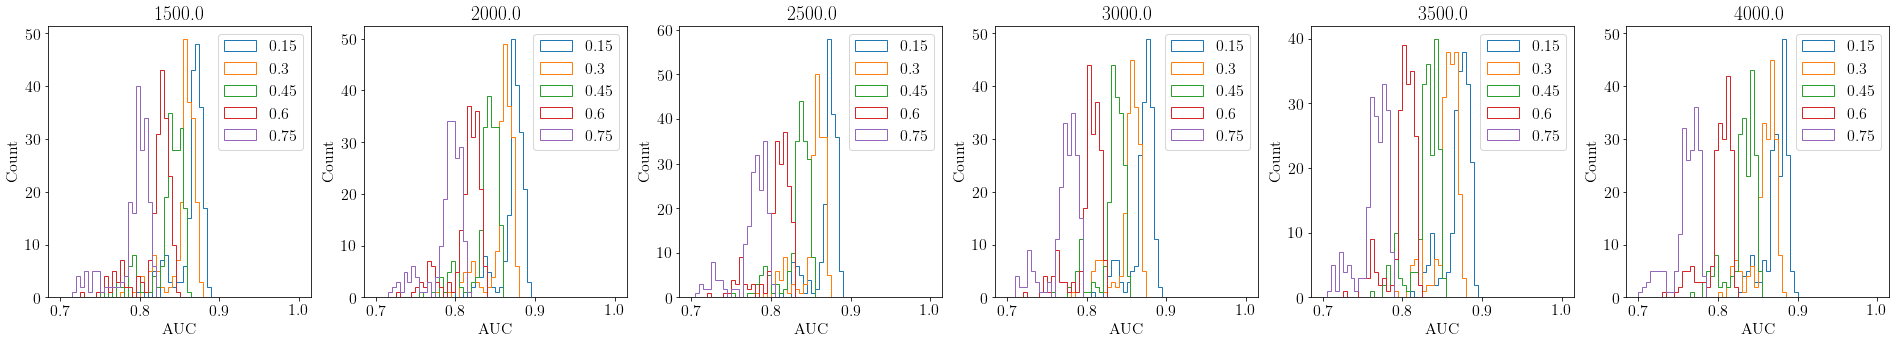

In [112]:
axis = 0
idx = np.asarray(map(list, res_aucs.index))
rows = list(np.unique(idx[:,axis]))
fig, axs = plt.subplots(1, len(rows), figsize=(5.5*len(rows), 5))

for cmb,row in res_aucs.iterrows():
    axs[rows.index(cmb[axis])].hist(row.values, histtype='step', bins=np.arange(.7, 1, .005), label=str(cmb[int(not axis)]))
for i,r in enumerate(rows):
    axs[rows.index(r)].set_xlabel('AUC')
    axs[rows.index(r)].set_title(r)
    axs[rows.index(r)].set_ylabel('Count')
    axs[rows.index(r)].legend()    

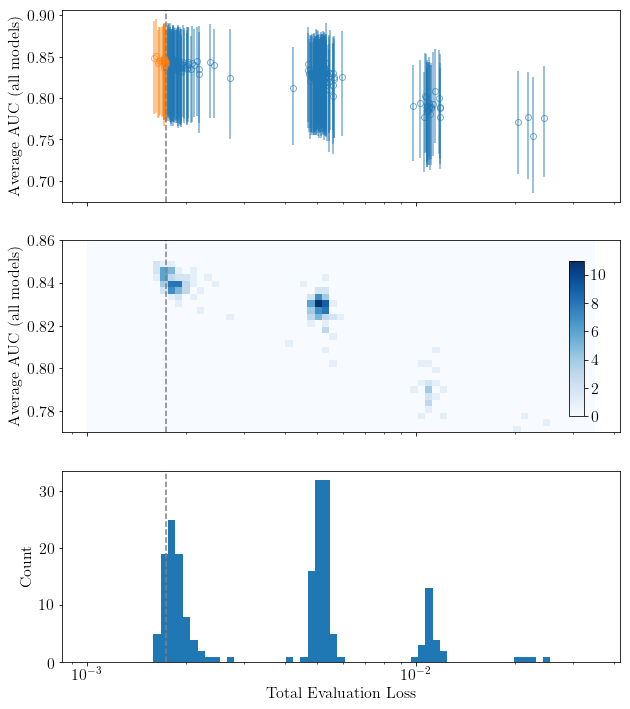

In [119]:
from matplotlib.ticker import LogFormatter

model_acceptance_fraction_ = 10

N = int(0.01*model_acceptance_fraction_*len(res))
keep = res.sort_values('total_loss').head(N)

fig, axes = plt.subplots(3, 1, figsize=(10,12), sharex=True)

x = res.set_index('filename').total_loss.sort_index()
y = res_aucs.mean()
yerr = np.asarray([(res_aucs.mean() - res_aucs.min()).values, (res_aucs.max()- res_aucs.mean()).values])
colors = np.asarray(list(map(lambda x: 'tab:blue' if not x else 'tab:orange', res_aucs.mean().index.isin(keep.filename))))

for color in np.unique(colors):
    idx = colors == color
    axes[0].errorbar(
        x[idx], y[idx], fmt='o', fillstyle='none', alpha=0.6, 
        yerr=yerr[:,idx], color=color
    )
# plt.xlim(0.0015, .0025)
wid = .18
cax = fig.add_axes([.83, 0.5 - wid/2, 0.02, wid])

axes[0].set_xscale('log')
axes[0].set_xticks([1e-3, 5e-3, 1e-2, 5e-2])
formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
axes[0].get_xaxis().set_minor_formatter(formatter)
axes[0].set_ylabel('Average AUC (all models)')


xbins, ybins = np.logspace(np.log10(.001), np.log10(0.035), 70), np.linspace(0.77, .86, 30)
cnts, xr, yr = np.histogram2d(x, y, bins=(xbins, ybins))
xm, ym = np.meshgrid(xr, yr)
im = axes[1].pcolormesh(xm, ym, cnts.T, cmap='Blues')
# axes[1].set_xlabel('Total Evaluation Loss')
axes[1].set_ylabel('Average AUC (all models)')
axes[1].set_xscale('log')
fig.colorbar(im, cax=cax, orientation='vertical')

axes[2].hist(res.total_loss, bins=xbins)
axes[2].set_xscale('log')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('Total Evaluation Loss')

for ax in axes:
    ax.axvline(keep.total_loss.max(), color='tab:grey', ls='--')

# plt.colorbar()
plt.show()